In [1]:
import seaborn as sn
from imblearn.over_sampling import SMOTE, SMOTENC 
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.utils import class_weight
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, multilabel_confusion_matrix, precision_score, precision_recall_curve, average_precision_score, classification_report
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from torch.utils.data import Dataset, DataLoader, random_split
from torch import Tensor
from torch.nn import Linear, ReLU, Sigmoid, Module, BCELoss, BCEWithLogitsLoss
from torch.optim import Adam
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from pandas import DataFrame
import xlsxwriter
import time

seed_value = 7
import os
os.environ['PYTHONHASHSEED']=str(seed_value)
import random
random.seed(seed_value)
import numpy as np
np.random.seed(seed_value)
import torch
torch.manual_seed(seed_value)

In [2]:
Training_Data = pd.ExcelFile("Scaled_Gilmore_Data_CT_SA_1_2.xlsx") #Training Data already pre-scaled to the IBIS Data set
Label_Data = pd.ExcelFile("Labels.xlsx") #Labels
data = Training_Data.parse(Training_Data.sheet_names[0])
label_data = Label_Data.parse(Label_Data.sheet_names[0])
data_features = data.loc[:, data.columns]
data_features = data_features.drop(['ROI','MATCH','INDEX','MATCH2','INDEX2', 'ATP', 'HYP', 'ATP Label', 'HYP Middle', 'HYP Label'], axis=1)
data_features = data_features.dropna()
data_features = data_features.drop(['ATP Middle'], axis=1)
labels = label_data.loc[:, label_data.columns]
labels = labels.drop(['ROI','ATP Label', 'HYP Middle', 'HYP Label'], axis=1)
labels = labels.dropna()
print(data_features.shape)
print(labels.shape)

(129, 298)
(129, 1)


In [3]:
skf = StratifiedKFold(n_splits=8)
skf.get_n_splits(data_features, labels)
print(skf)

training_indices_X = []
testing_indices_X = []
training_indices_Y = []
testing_indices_Y = []

for train_index, test_index in skf.split(data_features, labels):
  
    X_train, X_test = data_features.iloc[train_index], data_features.iloc[test_index]
    Y_train, Y_test = labels.iloc[train_index], labels.iloc[test_index]
   
    sm = SMOTE(sampling_strategy = 'minority', random_state = seed_value, k_neighbors=2) 
    X_train_res, Y_train_res = sm.fit_sample(X_train, Y_train) #Only smote the training set.
    print(X_train_res.shape)
    training_indices_X.append(X_train_res)
    testing_indices_X.append(X_test)
    training_indices_Y.append(Y_train_res)
    testing_indices_Y.append(Y_test)

print(type(testing_indices_X))
print(type(training_indices_X))

StratifiedKFold(n_splits=8, random_state=None, shuffle=False)
(186, 298)
(186, 298)
(186, 298)
(188, 298)
(188, 298)
(188, 298)
(188, 298)
(188, 298)
<class 'list'>
<class 'list'>


In [4]:
#training_indices_X[0] #8 Folds so 0 -> 7 Data type is a DataFrame currently.
training_fold_X_0 = training_indices_X[0].to_numpy()
training_fold_X_1 = training_indices_X[1].to_numpy()
training_fold_X_2 = training_indices_X[2].to_numpy()
training_fold_X_3 = training_indices_X[3].to_numpy()
training_fold_X_4 = training_indices_X[4].to_numpy()
training_fold_X_5 = training_indices_X[5].to_numpy()
training_fold_X_6 = training_indices_X[6].to_numpy()
training_fold_X_7 = training_indices_X[7].to_numpy()

training_fold_Y_0 = training_indices_Y[0].to_numpy()
training_fold_Y_1 = training_indices_Y[1].to_numpy()
training_fold_Y_2 = training_indices_Y[2].to_numpy()
training_fold_Y_3 = training_indices_Y[3].to_numpy()
training_fold_Y_4 = training_indices_Y[4].to_numpy()
training_fold_Y_5 = training_indices_Y[5].to_numpy()
training_fold_Y_6 = training_indices_Y[6].to_numpy()
training_fold_Y_7 = training_indices_Y[7].to_numpy()

testing_fold_X_0 = testing_indices_X[0].to_numpy()
testing_fold_X_1 = testing_indices_X[1].to_numpy()
testing_fold_X_2 = testing_indices_X[2].to_numpy()
testing_fold_X_3 = testing_indices_X[3].to_numpy()
testing_fold_X_4 = testing_indices_X[4].to_numpy()
testing_fold_X_5 = testing_indices_X[5].to_numpy()
testing_fold_X_6 = testing_indices_X[6].to_numpy()
testing_fold_X_7 = testing_indices_X[7].to_numpy()

testing_fold_Y_0 = testing_indices_Y[0].to_numpy()
testing_fold_Y_1 = testing_indices_Y[1].to_numpy()
testing_fold_Y_2 = testing_indices_Y[2].to_numpy()
testing_fold_Y_3 = testing_indices_Y[3].to_numpy()
testing_fold_Y_4 = testing_indices_Y[4].to_numpy()
testing_fold_Y_5 = testing_indices_Y[5].to_numpy()
testing_fold_Y_6 = testing_indices_Y[6].to_numpy()
testing_fold_Y_7 = testing_indices_Y[7].to_numpy()

In [5]:
#Some hyperparameters
#D_in is input dimension; H is hidden dimension; D_out is output dimension. 

#Best: 0.497768 using {'batch_size': 35, 'dropout': 0.3, 'epochs': 100, 'layer1_size': 100, 'layer2_size': 20}
D_in, H1, H2, D_out = 298, 100, 20, 1
EPOCHS = 100
BATCH_SIZE = 35
LEARNING_RATE = 0.001
DROPOUT_RATE = 0.30

test_size = 17
test_size1 = 16

## train data
class trainData(Dataset):
    
    def __init__(self, X_data, y_data): #used to perform initializing operations such as reading data and preprocessing.
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index): #returns data (input and output) in batches.
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self): #returns the size of the input data.
        return len(self.X_data)

#A dataloader is then used on this dataset class to read the data in batches.
train_data = trainData(torch.FloatTensor(training_fold_X_0), 
                       torch.FloatTensor(training_fold_Y_0))

train_data1 = trainData(torch.FloatTensor(training_fold_X_1), 
                       torch.FloatTensor(training_fold_Y_1))

train_data2 = trainData(torch.FloatTensor(training_fold_X_2), 
                       torch.FloatTensor(training_fold_Y_2))

train_data3 = trainData(torch.FloatTensor(training_fold_X_3), 
                       torch.FloatTensor(training_fold_Y_3))

train_data4 = trainData(torch.FloatTensor(training_fold_X_4), 
                       torch.FloatTensor(training_fold_Y_4))

train_data5 = trainData(torch.FloatTensor(training_fold_X_5), 
                       torch.FloatTensor(training_fold_Y_5))

train_data6 = trainData(torch.FloatTensor(training_fold_X_6), 
                       torch.FloatTensor(training_fold_Y_6))

train_data7 = trainData(torch.FloatTensor(training_fold_X_7), 
                       torch.FloatTensor(training_fold_Y_7))
## test data    
class testData(Dataset):
    
    def __init__(self, X_data): ##used to perform initializing operations such as reading data and preprocessing.
        self.X_data = X_data
        
    def __getitem__(self, index): #returns data (input and output) in batches.
        return self.X_data[index]
        
    def __len__ (self): #returns the size of the input data.
        return len(self.X_data)
    
#A dataloader is then used on this dataset class to read the data in batches.
test_data = testData(torch.FloatTensor(testing_fold_X_0))
test_data1 = testData(torch.FloatTensor(testing_fold_X_1))
test_data2 = testData(torch.FloatTensor(testing_fold_X_2))
test_data3 = testData(torch.FloatTensor(testing_fold_X_3))
test_data4 = testData(torch.FloatTensor(testing_fold_X_4))
test_data5 = testData(torch.FloatTensor(testing_fold_X_5))
test_data6 = testData(torch.FloatTensor(testing_fold_X_6))
test_data7 = testData(torch.FloatTensor(testing_fold_X_7))

#Initialize DataLoaders
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=test_size) #Batch size of the validation set. Need 1 at a time for how it was setup in the tutorial.

train_loader1 = DataLoader(dataset=train_data1, batch_size=BATCH_SIZE, shuffle=True)
test_loader1 = DataLoader(dataset=test_data1, batch_size=test_size1) #Batch size of the validation set. Need 1 at a time for how it was setup in the tutorial.

train_loader2 = DataLoader(dataset=train_data2, batch_size=BATCH_SIZE, shuffle=True)
test_loader2 = DataLoader(dataset=test_data2, batch_size=test_size1) #Batch size of the validation set. Need 1 at a time for how it was setup in the tutorial.

train_loader3 = DataLoader(dataset=train_data3, batch_size=BATCH_SIZE, shuffle=True)
test_loader3 = DataLoader(dataset=test_data3, batch_size=test_size1) #Batch size of the validation set. Need 1 at a time for how it was setup in the tutorial.

train_loader4 = DataLoader(dataset=train_data4, batch_size=BATCH_SIZE, shuffle=True)
test_loader4 = DataLoader(dataset=test_data4, batch_size=test_size1) #Batch size of the validation set. Need 1 at a time for how it was setup in the tutorial.

train_loader5 = DataLoader(dataset=train_data5, batch_size=BATCH_SIZE, shuffle=True)
test_loader5 = DataLoader(dataset=test_data5, batch_size=test_size1) #Batch size of the validation set. Need 1 at a time for how it was setup in the tutorial.

train_loader6 = DataLoader(dataset=train_data6, batch_size=BATCH_SIZE, shuffle=True)
test_loader6 = DataLoader(dataset=test_data6, batch_size=test_size1) #Batch size of the validation set. Need 1 at a time for how it was setup in the tutorial.

train_loader7 = DataLoader(dataset=train_data7, batch_size=BATCH_SIZE, shuffle=True)
test_loader7 = DataLoader(dataset=test_data7, batch_size=test_size1) #Batch size of the validation set. Need 1 at a time for how it was setup in the tutorial.

In [6]:
class binaryClassification(nn.Module):
    def __init__(self):
        super(binaryClassification, self).__init__()
        # Number of input features is 298.
        self.layer_1 = nn.Linear(D_in, H1) #298 -> 100
        self.layer_2 = nn.Linear(H1, H2) #100 -> 15
        self.layer_out = nn.Linear(H2, D_out) #15 -> 1
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=DROPOUT_RATE)
        #self.batchnorm1 = nn.BatchNorm1d(100)
        #self.batchnorm2 = nn.BatchNorm1d(15)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs)) #ReLU on the 298?
        #x = self.batchnorm1(x) #Normalize the 100
        x = self.dropout(x) #Dropout 15%
        x = self.relu(self.layer_2(x)) #ReLU on the 100?
        #x = self.batchnorm2(x) #Normalize the 15
        x = self.layer_out(x) #1
        
        return x
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
#Should use the CPU since I don't have a GPU.

cpu


In [7]:
#Model initialization and information on layers. The model's actual architecture can be viewed in the forward function above.
model = binaryClassification()
model.load_state_dict(torch.load('./model_dict_atp_simplified.pth'))
model.train()
print(model)
weights = torch.FloatTensor([5]) #Class weights?
criterion = nn.BCEWithLogitsLoss(pos_weight=weights)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

#Model initialization and information on layers. The model's actual architecture can be viewed in the forward function above.
model1 = binaryClassification()
model1.load_state_dict(torch.load('./model_dict_atp_simplified.pth'))
model1.train()
#print(model)
weights1 = torch.FloatTensor([5]) #Class weights?
criterion1 = nn.BCEWithLogitsLoss(pos_weight=weights1)
optimizer1 = optim.Adam(model1.parameters(), lr=LEARNING_RATE)

#Model initialization and information on layers. The model's actual architecture can be viewed in the forward function above.
model2 = binaryClassification()
model2.load_state_dict(torch.load('./model_dict_atp_simplified.pth'))
model2.train()
#print(model)
weights2 = torch.FloatTensor([5]) #Class weights?
criterion2 = nn.BCEWithLogitsLoss(pos_weight=weights2)
optimizer2 = optim.Adam(model2.parameters(), lr=LEARNING_RATE)

#Model initialization and information on layers. The model's actual architecture can be viewed in the forward function above.
model3 = binaryClassification()
model3.load_state_dict(torch.load('./model_dict_atp_simplified.pth'))
model3.train()
#print(model)
weights3 = torch.FloatTensor([5]) #Class weights?
criterion3 = nn.BCEWithLogitsLoss(pos_weight=weights3)
optimizer3 = optim.Adam(model3.parameters(), lr=LEARNING_RATE)

#Model initialization and information on layers. The model's actual architecture can be viewed in the forward function above.
model4 = binaryClassification()
model4.load_state_dict(torch.load('./model_dict_atp_simplified.pth'))
model4.train()
#print(model)
weights4 = torch.FloatTensor([5]) #Class weights?
criterion4 = nn.BCEWithLogitsLoss(pos_weight=weights4)
optimizer4 = optim.Adam(model4.parameters(), lr=LEARNING_RATE)

#Model initialization and information on layers. The model's actual architecture can be viewed in the forward function above.
model5 = binaryClassification()
model5.load_state_dict(torch.load('./model_dict_atp_simplified.pth'))
model5.train()
#print(model)
weights5 = torch.FloatTensor([5]) #Class weights?
criterion5 = nn.BCEWithLogitsLoss(pos_weight=weights5)
optimizer5 = optim.Adam(model5.parameters(), lr=LEARNING_RATE)

#Model initialization and information on layers. The model's actual architecture can be viewed in the forward function above.
model6 = binaryClassification()
model6.load_state_dict(torch.load('./model_dict_atp_simplified.pth'))
model6.train()
#print(model)
weights6 = torch.FloatTensor([5]) #Class weights?
criterion6 = nn.BCEWithLogitsLoss(pos_weight=weights6)
optimizer6 = optim.Adam(model6.parameters(), lr=LEARNING_RATE)

#Model initialization and information on layers. The model's actual architecture can be viewed in the forward function above.
model7 = binaryClassification()
model7.load_state_dict(torch.load('./model_dict_atp_simplified.pth'))
model7.train()
#print(model)
weights7 = torch.FloatTensor([5]) #Class weights?
criterion7 = nn.BCEWithLogitsLoss(pos_weight=weights7)
optimizer7 = optim.Adam(model7.parameters(), lr=LEARNING_RATE)

binaryClassification(
  (layer_1): Linear(in_features=298, out_features=100, bias=True)
  (layer_2): Linear(in_features=100, out_features=20, bias=True)
  (layer_out): Linear(in_features=20, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
)


In [8]:
#Function to define accuracy. Should look to see if there is a prebuilt that I can use from sci-kit learn or something.
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [9]:
#model.train() tells PyTorch that you’re in training mode.
#Similarly, we’ll call model.eval() when we test our model. We’ll see that below.
'''If you’re using layers such as Dropout or BatchNorm which behave differently during training and evaluation, 
you need to tell PyTorch to act accordingly. While the default mode in PyTorch is the train, 
so, you don’t explicitly have to write that. But it’s good practice.'''
val_acc = []
train_acc = []
train_loss = []
val_loss = []

model.train() #Initial training mode
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        
        y_pred = model(X_batch)
        
        loss = criterion(y_pred, y_batch)
        acc = binary_acc(y_pred, y_batch)
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    
    train_acc.append(epoch_acc/len(train_loader))
    train_loss.append(epoch_loss/len(train_loader))
    print(f'Training Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')
    #Validation metrics here
    model.eval()
    #print("Evaluation mode")
    y_pred_list = []
    test_loader = DataLoader(dataset=test_data, batch_size=test_size)
    with torch.no_grad():
        counter = 0
        for X_batch in test_loader:
            X_batch = X_batch.to(device)
            y_test_pred = model(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            loss = criterion(y_test_pred,torch.FloatTensor(testing_fold_Y_0))
            val_loss.append(loss)
            counter+=1
            
    y_pred_list = []
    test_loader = DataLoader(dataset=test_data, batch_size=1)
    with torch.no_grad():
        for X_batch in test_loader:
            X_batch = X_batch.to(device)
            y_test_pred = model(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            
    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
    y_loss_df = pd.DataFrame(y_pred_list)
    accuracy = accuracy_score(torch.FloatTensor(testing_fold_Y_0), y_pred_list)
    ppv = precision_score(testing_fold_Y_0, y_pred_list, average=None)
    recall = recall_score(testing_fold_Y_0, y_pred_list, average=None)
    print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
    val_acc.append(accuracy*100)
    model.train()
    #print("Return to training mode")
    
    #Need to get validation loss.

Training Epoch 001: | Loss: 3.53109 | Acc: 53.333
Validation Accuracy |  17.647058823529413  PPV |  [0.         0.17647059]  Recall |  [0. 1.]
Training Epoch 002: | Loss: 2.13218 | Acc: 54.000
Validation Accuracy |  17.647058823529413  PPV |  [0.         0.17647059]  Recall |  [0. 1.]
Training Epoch 003: | Loss: 2.02094 | Acc: 48.333
Validation Accuracy |  17.647058823529413  PPV |  [0.         0.17647059]  Recall |  [0. 1.]
Training Epoch 004: | Loss: 1.48289 | Acc: 54.333
Validation Accuracy |  17.647058823529413  PPV |  [0.         0.17647059]  Recall |  [0. 1.]
Training Epoch 005: | Loss: 1.39987 | Acc: 53.833
Validation Accuracy |  23.52941176470588  PPV |  [1.     0.1875]  Recall |  [0.07142857 1.        ]
Training Epoch 006: | Loss: 1.42451 | Acc: 54.500


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\s

Validation Accuracy |  17.647058823529413  PPV |  [0.         0.17647059]  Recall |  [0. 1.]
Training Epoch 007: | Loss: 1.27509 | Acc: 54.000
Validation Accuracy |  17.647058823529413  PPV |  [0.         0.17647059]  Recall |  [0. 1.]
Training Epoch 008: | Loss: 1.32799 | Acc: 47.167
Validation Accuracy |  17.647058823529413  PPV |  [0.         0.17647059]  Recall |  [0. 1.]
Training Epoch 009: | Loss: 1.24281 | Acc: 56.667
Validation Accuracy |  17.647058823529413  PPV |  [0.         0.17647059]  Recall |  [0. 1.]
Training Epoch 010: | Loss: 1.22340 | Acc: 53.333
Validation Accuracy |  17.647058823529413  PPV |  [0.         0.17647059]  Recall |  [0. 1.]
Training Epoch 011: | Loss: 1.26552 | Acc: 50.667


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\s

Validation Accuracy |  17.647058823529413  PPV |  [0.         0.17647059]  Recall |  [0. 1.]
Training Epoch 012: | Loss: 1.22750 | Acc: 51.833
Validation Accuracy |  17.647058823529413  PPV |  [0.         0.17647059]  Recall |  [0. 1.]
Training Epoch 013: | Loss: 1.20592 | Acc: 56.833
Validation Accuracy |  17.647058823529413  PPV |  [0.         0.17647059]  Recall |  [0. 1.]
Training Epoch 014: | Loss: 1.13008 | Acc: 56.500
Validation Accuracy |  29.411764705882355  PPV |  [1.  0.2]  Recall |  [0.14285714 1.        ]
Training Epoch 015: | Loss: 1.13206 | Acc: 55.500
Validation Accuracy |  29.411764705882355  PPV |  [1.  0.2]  Recall |  [0.14285714 1.        ]
Training Epoch 016: | Loss: 1.09819 | Acc: 59.167
Validation Accuracy |  

C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


35.294117647058826  PPV |  [1.         0.21428571]  Recall |  [0.21428571 1.        ]
Training Epoch 017: | Loss: 1.09004 | Acc: 66.500
Validation Accuracy |  35.294117647058826  PPV |  [1.         0.21428571]  Recall |  [0.21428571 1.        ]
Training Epoch 018: | Loss: 1.11591 | Acc: 59.500
Validation Accuracy |  29.411764705882355  PPV |  [1.  0.2]  Recall |  [0.14285714 1.        ]
Training Epoch 019: | Loss: 1.10378 | Acc: 62.167
Validation Accuracy |  35.294117647058826  PPV |  [1.         0.21428571]  Recall |  [0.21428571 1.        ]
Training Epoch 020: | Loss: 0.96924 | Acc: 65.500
Validation Accuracy |  35.294117647058826  PPV |  [1.         0.21428571]  Recall |  [0.21428571 1.        ]
Training Epoch 021: | Loss: 0.98763 | Acc: 69.833
Validation Accuracy |  35.294117647058826  PPV |  [1.         0.21428571]  Recall |  [0.21428571 1.        ]
Training Epoch 022: | Loss: 0.93425 | Acc: 69.333
Validation Accuracy |  41.17647058823529  PPV |  [1.         0.23076923]  Recall | 

Validation Accuracy |  64.70588235294117  PPV |  [0.83333333 0.2       ]  Recall |  [0.71428571 0.33333333]
Training Epoch 074: | Loss: 0.08006 | Acc: 99.000
Validation Accuracy |  70.58823529411765  PPV |  [0.84615385 0.25      ]  Recall |  [0.78571429 0.33333333]
Training Epoch 075: | Loss: 0.06156 | Acc: 100.000
Validation Accuracy |  70.58823529411765  PPV |  [0.84615385 0.25      ]  Recall |  [0.78571429 0.33333333]
Training Epoch 076: | Loss: 0.05433 | Acc: 99.000
Validation Accuracy |  70.58823529411765  PPV |  [0.84615385 0.25      ]  Recall |  [0.78571429 0.33333333]
Training Epoch 077: | Loss: 0.06001 | Acc: 100.000
Validation Accuracy |  64.70588235294117  PPV |  [0.83333333 0.2       ]  Recall |  [0.71428571 0.33333333]
Training Epoch 078: | Loss: 0.05646 | Acc: 99.000
Validation Accuracy |  70.58823529411765  PPV |  [0.84615385 0.25      ]  Recall |  [0.78571429 0.33333333]
Training Epoch 079: | Loss: 0.05321 | Acc: 100.000
Validation Accuracy |  76.47058823529412  PPV |  

In [10]:
#model.train() tells PyTorch that you’re in training mode.
#Similarly, we’ll call model.eval() when we test our model. We’ll see that below.
'''If you’re using layers such as Dropout or BatchNorm which behave differently during training and evaluation, 
you need to tell PyTorch to act accordingly. While the default mode in PyTorch is the train, 
so, you don’t explicitly have to write that. But it’s good practice.'''
val_acc1 = []
train_acc1 = []
train_loss1 = []
val_loss1 = []

model1.train() #Initial training mode
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader1:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer1.zero_grad()
        
        y_pred = model1(X_batch)
        
        loss = criterion(y_pred, y_batch)
        acc = binary_acc(y_pred, y_batch)
        
        loss.backward()
        optimizer1.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    
    train_acc1.append(epoch_acc/len(train_loader1))
    train_loss1.append(epoch_loss/len(train_loader1))
    print(f'Training Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader1):.5f} | Acc: {epoch_acc/len(train_loader1):.3f}')
    #Validation metrics here
    model1.eval()
    #print("Evaluation mode")
    y_pred_list = []
    test_loader1 = DataLoader(dataset=test_data1, batch_size=test_size1)
    with torch.no_grad():
        counter = 0
        for X_batch in test_loader1:
            X_batch = X_batch.to(device)
            y_test_pred = model1(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            loss = criterion(y_test_pred,torch.FloatTensor(testing_fold_Y_1))
            val_loss1.append(loss)
            counter+=1
            
    y_pred_list = []
    test_loader = DataLoader(dataset=test_data1, batch_size=1)
    with torch.no_grad():
        for X_batch in test_loader:
            X_batch = X_batch.to(device)
            y_test_pred = model1(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            
    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
    y_loss_df = pd.DataFrame(y_pred_list)
    accuracy = accuracy_score(torch.FloatTensor(testing_fold_Y_1), y_pred_list)
    ppv = precision_score(testing_fold_Y_1, y_pred_list, average=None)
    recall = recall_score(testing_fold_Y_1, y_pred_list, average=None)
    print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
    val_acc1.append(accuracy*100)
    model1.train()
    #print("Return to training mode")
    
    #Need to get validation loss.

Training Epoch 001: | Loss: 2.82729 | Acc: 60.333
Validation Accuracy |  12.5  PPV |  [0.    0.125]  Recall |  [0. 1.]
Training Epoch 002: | Loss: 1.90722 | Acc: 54.167
Validation Accuracy |  12.5  PPV |  [0.    0.125]  Recall |  [0. 1.]
Training Epoch 003: | Loss: 1.71329 | Acc: 51.500
Validation Accuracy |  12.5  PPV |  [0.    0.125]  Recall |  [0. 1.]
Training Epoch 004: | Loss: 1.31809 | Acc: 52.000
Validation Accuracy |  12.5  PPV |  [0.5        0.07142857]  Recall |  [0.07142857 0.5       ]
Training Epoch 005: | Loss: 1.25552 | Acc: 61.667
Validation Accuracy |  6.25  PPV |  [0.         0.06666667]  Recall |  [0.  0.5]
Training Epoch 006: | Loss: 1.30607 | Acc: 57.000


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\s

Validation Accuracy |  12.5  PPV |  [0.    0.125]  Recall |  [0. 1.]
Training Epoch 007: | Loss: 1.21550 | Acc: 58.500
Validation Accuracy |  12.5  PPV |  [0.    0.125]  Recall |  [0. 1.]
Training Epoch 008: | Loss: 1.19772 | Acc: 55.167
Validation Accuracy |  12.5  PPV |  [0.    0.125]  Recall |  [0. 1.]
Training Epoch 009: | Loss: 1.08396 | Acc: 57.333
Validation Accuracy |  6.25  PPV |  [0.         0.06666667]  Recall |  [0.  0.5]
Training Epoch 010: | Loss: 1.11700 | Acc: 60.667
Validation Accuracy |  12.5  PPV |  [0.5        0.07142857]  Recall |  [0.07142857 0.5       ]
Training Epoch 011: | Loss: 1.07446 | Acc: 62.500
Validation Accuracy |  12.5  PPV |  [0.5        0.07142857]  Recall |  [0.07142857 0.5       ]


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training Epoch 012: | Loss: 0.99389 | Acc: 64.500
Validation Accuracy |  12.5  PPV |  [0.5        0.07142857]  Recall |  [0.07142857 0.5       ]
Training Epoch 013: | Loss: 1.08003 | Acc: 64.833
Validation Accuracy |  12.5  PPV |  [0.5        0.07142857]  Recall |  [0.07142857 0.5       ]
Training Epoch 014: | Loss: 1.01717 | Acc: 62.667
Validation Accuracy |  6.25  PPV |  [0.         0.06666667]  Recall |  [0.  0.5]
Training Epoch 015: | Loss: 1.01531 | Acc: 61.667
Validation Accuracy |  12.5  PPV |  [0.5        0.07142857]  Recall |  [0.07142857 0.5       ]
Training Epoch 016: | Loss: 0.92959 | Acc: 71.500
Validation Accuracy |  43.75  PPV |  [0.85714286 0.11111111]  Recall |  [0.42857143 0.5       ]
Training Epoch 017: | Loss: 0.90379 | Acc: 73.000
Validation Accuracy |  12.5  PPV |  [0.5        0.07142857]  Recall |  [0.07142857 0.5       ]
Training Epoch 018: | Loss: 0.89061 | Acc: 67.000
Validation Accuracy |  25.0  PPV |  [0.75       0.08333333]  Recall |  [0.21428571 0.5       

Validation Accuracy |  68.75  PPV |  [0.84615385 0.        ]  Recall |  [0.78571429 0.        ]
Training Epoch 070: | Loss: 0.04529 | Acc: 99.000
Validation Accuracy |  68.75  PPV |  [0.84615385 0.        ]  Recall |  [0.78571429 0.        ]
Training Epoch 071: | Loss: 0.03235 | Acc: 100.000
Validation Accuracy |  75.0  PPV |  [0.85714286 0.        ]  Recall |  [0.85714286 0.        ]
Training Epoch 072: | Loss: 0.03499 | Acc: 100.000
Validation Accuracy |  75.0  PPV |  [0.85714286 0.        ]  Recall |  [0.85714286 0.        ]
Training Epoch 073: | Loss: 0.02530 | Acc: 100.000
Validation Accuracy |  75.0  PPV |  [0.85714286 0.        ]  Recall |  [0.85714286 0.        ]
Training Epoch 074: | Loss: 0.03398 | Acc: 99.500
Validation Accuracy |  68.75  PPV |  [0.84615385 0.        ]  Recall |  [0.78571429 0.        ]
Training Epoch 075: | Loss: 0.02775 | Acc: 100.000
Validation Accuracy |  75.0  PPV |  [0.85714286 0.        ]  Recall |  [0.85714286 0.        ]
Training Epoch 076: | Loss: 

In [11]:
#model.train() tells PyTorch that you’re in training mode.
#Similarly, we’ll call model.eval() when we test our model. We’ll see that below.
'''If you’re using layers such as Dropout or BatchNorm which behave differently during training and evaluation, 
you need to tell PyTorch to act accordingly. While the default mode in PyTorch is the train, 
so, you don’t explicitly have to write that. But it’s good practice.'''
val_acc2 = []
train_acc2 = []
train_loss2 = []
val_loss2 = []

model2.train() #Initial training mode
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader2:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer2.zero_grad()
        
        y_pred = model2(X_batch)
        
        loss = criterion(y_pred, y_batch)
        acc = binary_acc(y_pred, y_batch)
        
        loss.backward()
        optimizer2.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    
    train_acc2.append(epoch_acc/len(train_loader2))
    train_loss2.append(epoch_loss/len(train_loader2))
    print(f'Training Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader2):.5f} | Acc: {epoch_acc/len(train_loader2):.3f}')
    #Validation metrics here
    model2.eval()
    #print("Evaluation mode")
    y_pred_list = []
    test_loader2 = DataLoader(dataset=test_data2, batch_size=test_size1)
    with torch.no_grad():
        counter = 0
        for X_batch in test_loader2:
            X_batch = X_batch.to(device)
            y_test_pred = model2(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            loss = criterion(y_test_pred,torch.FloatTensor(testing_fold_Y_2))
            val_loss2.append(loss)
            counter+=1
            
    y_pred_list = []
    test_loader2 = DataLoader(dataset=test_data2, batch_size=1)
    with torch.no_grad():
        for X_batch in test_loader2:
            X_batch = X_batch.to(device)
            y_test_pred = model2(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            
    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
    y_loss_df = pd.DataFrame(y_pred_list)
    accuracy = accuracy_score(torch.FloatTensor(testing_fold_Y_2), y_pred_list)
    ppv = precision_score(testing_fold_Y_2, y_pred_list, average=None)
    recall = recall_score(testing_fold_Y_2, y_pred_list, average=None)
    print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
    val_acc2.append(accuracy*100)
    model2.train()
    #print("Return to training mode")
    
    #Need to get validation loss.

Training Epoch 001: | Loss: 3.76314 | Acc: 48.167
Validation Accuracy |  25.0  PPV |  [1.         0.14285714]  Recall |  [0.14285714 1.        ]
Training Epoch 002: | Loss: 2.00630 | Acc: 50.333
Validation Accuracy |  18.75  PPV |  [1.         0.13333333]  Recall |  [0.07142857 1.        ]
Training Epoch 003: | Loss: 1.70529 | Acc: 53.000
Validation Accuracy |  18.75  PPV |  [1.         0.13333333]  Recall |  [0.07142857 1.        ]
Training Epoch 004: | Loss: 1.45805 | Acc: 51.500
Validation Accuracy |  25.0  PPV |  [1.         0.14285714]  Recall |  [0.14285714 1.        ]
Training Epoch 005: | Loss: 1.38019 | Acc: 58.000
Validation Accuracy |  25.0  PPV |  [1.         0.14285714]  Recall |  [0.14285714 1.        ]
Training Epoch 006: | Loss: 1.34707 | Acc: 52.000
Validation Accuracy |  18.75  PPV |  [1.         0.13333333]  Recall |  [0.07142857 1.        ]
Training Epoch 007: | Loss: 1.25134 | Acc: 55.333
Validation Accuracy |  18.75  PPV |  [1.         0.13333333]  Recall |  [0.07

Training Epoch 060: | Loss: 0.08430 | Acc: 98.000
Validation Accuracy |  75.0  PPV |  [0.85714286 0.        ]  Recall |  [0.85714286 0.        ]
Training Epoch 061: | Loss: 0.07434 | Acc: 99.500
Validation Accuracy |  75.0  PPV |  [0.85714286 0.        ]  Recall |  [0.85714286 0.        ]
Training Epoch 062: | Loss: 0.08387 | Acc: 98.500
Validation Accuracy |  75.0  PPV |  [0.85714286 0.        ]  Recall |  [0.85714286 0.        ]
Training Epoch 063: | Loss: 0.08569 | Acc: 98.500
Validation Accuracy |  75.0  PPV |  [0.85714286 0.        ]  Recall |  [0.85714286 0.        ]
Training Epoch 064: | Loss: 0.07015 | Acc: 99.000
Validation Accuracy |  75.0  PPV |  [0.85714286 0.        ]  Recall |  [0.85714286 0.        ]
Training Epoch 065: | Loss: 0.08703 | Acc: 99.500
Validation Accuracy |  75.0  PPV |  [0.85714286 0.        ]  Recall |  [0.85714286 0.        ]
Training Epoch 066: | Loss: 0.06299 | Acc: 99.000
Validation Accuracy |  75.0  PPV |  [0.85714286 0.        ]  Recall |  [0.857142

In [12]:
#model.train() tells PyTorch that you’re in training mode.
#Similarly, we’ll call model.eval() when we test our model. We’ll see that below.
'''If you’re using layers such as Dropout or BatchNorm which behave differently during training and evaluation, 
you need to tell PyTorch to act accordingly. While the default mode in PyTorch is the train, 
so, you don’t explicitly have to write that. But it’s good practice.'''
val_acc3 = []
train_acc3 = []
train_loss3 = []
val_loss3 = []

model3.train() #Initial training mode
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader3:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer3.zero_grad()
        
        y_pred = model3(X_batch)
        
        loss = criterion(y_pred, y_batch)
        acc = binary_acc(y_pred, y_batch)
        
        loss.backward()
        optimizer3.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    
    train_acc3.append(epoch_acc/len(train_loader3))
    train_loss3.append(epoch_loss/len(train_loader3))
    print(f'Training Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader3):.5f} | Acc: {epoch_acc/len(train_loader3):.3f}')
    #Validation metrics here
    model3.eval()
    #print("Evaluation mode")
    y_pred_list = []
    test_loader3 = DataLoader(dataset=test_data3, batch_size=test_size1)
    with torch.no_grad():
        counter = 0
        for X_batch in test_loader3:
            X_batch = X_batch.to(device)
            y_test_pred = model3(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            loss = criterion(y_test_pred,torch.FloatTensor(testing_fold_Y_3))
            val_loss3.append(loss)
            counter+=1
            
    y_pred_list = []
    test_loader3 = DataLoader(dataset=test_data3, batch_size=1)
    with torch.no_grad():
        for X_batch in test_loader3:
            X_batch = X_batch.to(device)
            y_test_pred = model3(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            
    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
    y_loss_df = pd.DataFrame(y_pred_list)
    accuracy = accuracy_score(torch.FloatTensor(testing_fold_Y_3), y_pred_list)
    ppv = precision_score(testing_fold_Y_3, y_pred_list, average=None)
    recall = recall_score(testing_fold_Y_3, y_pred_list, average=None)
    print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
    val_acc3.append(accuracy*100)
    model3.train()
    #print("Return to training mode")
    
    #Need to get validation loss.

Training Epoch 001: | Loss: 2.95603 | Acc: 56.167
Validation Accuracy |  18.75  PPV |  [0.     0.1875]  Recall |  [0. 1.]
Training Epoch 002: | Loss: 1.85642 | Acc: 51.000
Validation Accuracy |  18.75  PPV |  [0.     0.1875]  Recall |  [0. 1.]
Training Epoch 003: | Loss: 1.49461 | Acc: 55.000
Validation Accuracy |  25.0  PPV |  [1.  0.2]  Recall |  [0.07692308 1.        ]
Training Epoch 004: | Loss: 1.27993 | Acc: 58.833
Validation Accuracy |  25.0  PPV |  [1.  0.2]  Recall |  [0.07692308 1.        ]
Training Epoch 005: | Loss: 1.33463 | Acc: 56.667
Validation Accuracy |  18.75  PPV |  [0.     0.1875]  Recall |  [0. 1.]
Training Epoch 006: | Loss: 1.22992 | Acc: 54.500
Validation Accuracy |  18.75  PPV |  [0.     0.1875]  Recall |  [0. 1.]
Training Epoch 007: | Loss: 1.18620 | Acc: 56.000


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\s

Validation Accuracy |  18.75  PPV |  [0.     0.1875]  Recall |  [0. 1.]
Training Epoch 008: | Loss: 1.20756 | Acc: 61.000
Validation Accuracy |  25.0  PPV |  [1.  0.2]  Recall |  [0.07692308 1.        ]
Training Epoch 009: | Loss: 1.12145 | Acc: 58.833
Validation Accuracy |  18.75  PPV |  [0.     0.1875]  Recall |  [0. 1.]
Training Epoch 010: | Loss: 1.11094 | Acc: 58.333
Validation Accuracy |  25.0  PPV |  [1.  0.2]  Recall |  [0.07692308 1.        ]
Training Epoch 011: | Loss: 1.03756 | Acc: 65.000
Validation Accuracy |  12.5  PPV |  [0.33333333 0.07692308]  Recall |  [0.07692308 0.33333333]
Training Epoch 012: | Loss: 0.97631 | Acc: 71.333
Validation Accuracy |  12.5  PPV |  [0.33333333 0.07692308]  Recall |  [0.07692308 0.33333333]
Training Epoch 013: | Loss: 1.00941 | Acc: 70.167
Validation Accuracy |  12.5  PPV |  [0.         0.13333333]  Recall |  [0.         0.66666667]
Training Epoch 014: | Loss: 0.89789 | Acc: 66.333
Validation Accuracy |  12.5  PPV |  [0.33333333 0.07692308]

C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training Epoch 016: | Loss: 0.82712 | Acc: 72.000
Validation Accuracy |  31.25  PPV |  [0.66666667 0.1       ]  Recall |  [0.30769231 0.33333333]
Training Epoch 017: | Loss: 0.83826 | Acc: 78.500
Validation Accuracy |  31.25  PPV |  [0.66666667 0.1       ]  Recall |  [0.30769231 0.33333333]
Training Epoch 018: | Loss: 0.71827 | Acc: 74.667
Validation Accuracy |  25.0  PPV |  [0.6        0.09090909]  Recall |  [0.23076923 0.33333333]
Training Epoch 019: | Loss: 0.66396 | Acc: 79.167
Validation Accuracy |  31.25  PPV |  [0.66666667 0.1       ]  Recall |  [0.30769231 0.33333333]
Training Epoch 020: | Loss: 0.73056 | Acc: 84.667
Validation Accuracy |  31.25  PPV |  [0.66666667 0.1       ]  Recall |  [0.30769231 0.33333333]
Training Epoch 021: | Loss: 0.66783 | Acc: 76.333
Validation Accuracy |  31.25  PPV |  [0.66666667 0.1       ]  Recall |  [0.30769231 0.33333333]
Training Epoch 022: | Loss: 0.65559 | Acc: 85.667
Validation Accuracy |  50.0  PPV |  [0.77777778 0.14285714]  Recall |  [0.5

Validation Accuracy |  75.0  PPV |  [0.84615385 0.33333333]  Recall |  [0.84615385 0.33333333]
Training Epoch 074: | Loss: 0.04098 | Acc: 100.000
Validation Accuracy |  75.0  PPV |  [0.84615385 0.33333333]  Recall |  [0.84615385 0.33333333]
Training Epoch 075: | Loss: 0.03617 | Acc: 99.000
Validation Accuracy |  81.25  PPV |  [0.85714286 0.5       ]  Recall |  [0.92307692 0.33333333]
Training Epoch 076: | Loss: 0.06222 | Acc: 98.167
Validation Accuracy |  81.25  PPV |  [0.85714286 0.5       ]  Recall |  [0.92307692 0.33333333]
Training Epoch 077: | Loss: 0.03693 | Acc: 100.000
Validation Accuracy |  81.25  PPV |  [0.85714286 0.5       ]  Recall |  [0.92307692 0.33333333]
Training Epoch 078: | Loss: 0.02772 | Acc: 100.000
Validation Accuracy |  75.0  PPV |  [0.84615385 0.33333333]  Recall |  [0.84615385 0.33333333]
Training Epoch 079: | Loss: 0.03113 | Acc: 100.000
Validation Accuracy |  81.25  PPV |  [0.85714286 0.5       ]  Recall |  [0.92307692 0.33333333]
Training Epoch 080: | Loss:

In [13]:
#model.train() tells PyTorch that you’re in training mode.
#Similarly, we’ll call model.eval() when we test our model. We’ll see that below.
'''If you’re using layers such as Dropout or BatchNorm which behave differently during training and evaluation, 
you need to tell PyTorch to act accordingly. While the default mode in PyTorch is the train, 
so, you don’t explicitly have to write that. But it’s good practice.'''
val_acc4 = []
train_acc4 = []
train_loss4 = []
val_loss4 = []

model4.train() #Initial training mode
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader4:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer4.zero_grad()
        
        y_pred = model4(X_batch)
        
        loss = criterion(y_pred, y_batch)
        acc = binary_acc(y_pred, y_batch)
        
        loss.backward()
        optimizer4.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    
    train_acc4.append(epoch_acc/len(train_loader4))
    train_loss4.append(epoch_loss/len(train_loader4))
    print(f'Training Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader4):.5f} | Acc: {epoch_acc/len(train_loader4):.3f}')
    #Validation metrics here
    model4.eval()
    #print("Evaluation mode")
    y_pred_list = []
    test_loader4 = DataLoader(dataset=test_data4, batch_size=test_size1)
    with torch.no_grad():
        counter = 0
        for X_batch in test_loader4:
            X_batch = X_batch.to(device)
            y_test_pred = model4(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            loss = criterion(y_test_pred,torch.FloatTensor(testing_fold_Y_4))
            val_loss4.append(loss)
            counter+=1
            
    y_pred_list = []
    test_loader4 = DataLoader(dataset=test_data4, batch_size=1)
    with torch.no_grad():
        for X_batch in test_loader4:
            X_batch = X_batch.to(device)
            y_test_pred = model4(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            
    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
    y_loss_df = pd.DataFrame(y_pred_list)
    accuracy = accuracy_score(torch.FloatTensor(testing_fold_Y_4), y_pred_list)
    ppv = precision_score(testing_fold_Y_4, y_pred_list, average=None)
    recall = recall_score(testing_fold_Y_4, y_pred_list, average=None)
    print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
    val_acc4.append(accuracy*100)
    model4.train()
    #print("Return to training mode")
    
    #Need to get validation loss.

Training Epoch 001: | Loss: 3.29822 | Acc: 52.500
Validation Accuracy |  25.0  PPV |  [1.  0.2]  Recall |  [0.07692308 1.        ]
Training Epoch 002: | Loss: 1.82877 | Acc: 51.167
Validation Accuracy |  25.0  PPV |  [1.  0.2]  Recall |  [0.07692308 1.        ]
Training Epoch 003: | Loss: 1.64555 | Acc: 51.000
Validation Accuracy |  25.0  PPV |  [1.  0.2]  Recall |  [0.07692308 1.        ]
Training Epoch 004: | Loss: 1.40999 | Acc: 50.667
Validation Accuracy |  25.0  PPV |  [1.  0.2]  Recall |  [0.07692308 1.        ]
Training Epoch 005: | Loss: 1.41954 | Acc: 53.667
Validation Accuracy |  25.0  PPV |  [1.  0.2]  Recall |  [0.07692308 1.        ]
Training Epoch 006: | Loss: 1.38002 | Acc: 51.167
Validation Accuracy |  25.0  PPV |  [1.  0.2]  Recall |  [0.07692308 1.        ]
Training Epoch 007: | Loss: 1.31785 | Acc: 53.667
Validation Accuracy |  25.0  PPV |  [1.  0.2]  Recall |  [0.07692308 1.        ]
Training Epoch 008: | Loss: 1.24156 | Acc: 54.167
Validation Accuracy |  25.0  PPV 

Validation Accuracy |  81.25  PPV |  [0.91666667 0.5       ]  Recall |  [0.84615385 0.66666667]
Training Epoch 061: | Loss: 0.09573 | Acc: 99.000
Validation Accuracy |  81.25  PPV |  [0.91666667 0.5       ]  Recall |  [0.84615385 0.66666667]
Training Epoch 062: | Loss: 0.09505 | Acc: 98.000
Validation Accuracy |  81.25  PPV |  [0.91666667 0.5       ]  Recall |  [0.84615385 0.66666667]
Training Epoch 063: | Loss: 0.08280 | Acc: 99.000
Validation Accuracy |  81.25  PPV |  [0.91666667 0.5       ]  Recall |  [0.84615385 0.66666667]
Training Epoch 064: | Loss: 0.09018 | Acc: 98.500
Validation Accuracy |  81.25  PPV |  [0.91666667 0.5       ]  Recall |  [0.84615385 0.66666667]
Training Epoch 065: | Loss: 0.12217 | Acc: 98.167
Validation Accuracy |  81.25  PPV |  [0.91666667 0.5       ]  Recall |  [0.84615385 0.66666667]
Training Epoch 066: | Loss: 0.07630 | Acc: 99.000
Validation Accuracy |  81.25  PPV |  [0.91666667 0.5       ]  Recall |  [0.84615385 0.66666667]
Training Epoch 067: | Loss: 

In [14]:
#model.train() tells PyTorch that you’re in training mode.
#Similarly, we’ll call model.eval() when we test our model. We’ll see that below.
'''If you’re using layers such as Dropout or BatchNorm which behave differently during training and evaluation, 
you need to tell PyTorch to act accordingly. While the default mode in PyTorch is the train, 
so, you don’t explicitly have to write that. But it’s good practice.'''
val_acc5 = []
train_acc5 = []
train_loss5 = []
val_loss5 = []

model5.train() #Initial training mode
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader5:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer5.zero_grad()
        
        y_pred = model5(X_batch)
        
        loss = criterion(y_pred, y_batch)
        acc = binary_acc(y_pred, y_batch)
        
        loss.backward()
        optimizer5.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    
    train_acc5.append(epoch_acc/len(train_loader5))
    train_loss5.append(epoch_loss/len(train_loader5))
    print(f'Training Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader5):.5f} | Acc: {epoch_acc/len(train_loader5):.3f}')
    #Validation metrics here
    model5.eval()
    #print("Evaluation mode")
    y_pred_list = []
    test_loader5 = DataLoader(dataset=test_data5, batch_size=test_size1)
    with torch.no_grad():
        counter = 0
        for X_batch in test_loader5:
            X_batch = X_batch.to(device)
            y_test_pred = model5(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            loss = criterion(y_test_pred,torch.FloatTensor(testing_fold_Y_5))
            val_loss5.append(loss)
            counter+=1
            
    y_pred_list = []
    test_loader5 = DataLoader(dataset=test_data5, batch_size=1)
    with torch.no_grad():
        for X_batch in test_loader5:
            X_batch = X_batch.to(device)
            y_test_pred = model5(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            
    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
    y_loss_df = pd.DataFrame(y_pred_list)
    accuracy = accuracy_score(torch.FloatTensor(testing_fold_Y_5), y_pred_list)
    ppv = precision_score(testing_fold_Y_5, y_pred_list, average=None)
    recall = recall_score(testing_fold_Y_5, y_pred_list, average=None)
    print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
    val_acc5.append(accuracy*100)
    model5.train()
    #print("Return to training mode")
    
    #Need to get validation loss.

Training Epoch 001: | Loss: 3.66714 | Acc: 54.167
Validation Accuracy |  25.0  PPV |  [1.  0.2]  Recall |  [0.07692308 1.        ]
Training Epoch 002: | Loss: 2.06944 | Acc: 50.500
Validation Accuracy |  25.0  PPV |  [1.  0.2]  Recall |  [0.07692308 1.        ]
Training Epoch 003: | Loss: 1.95706 | Acc: 50.167
Validation Accuracy |  25.0  PPV |  [1.  0.2]  Recall |  [0.07692308 1.        ]
Training Epoch 004: | Loss: 1.55706 | Acc: 49.833
Validation Accuracy |  25.0  PPV |  [1.  0.2]  Recall |  [0.07692308 1.        ]
Training Epoch 005: | Loss: 1.32779 | Acc: 55.667
Validation Accuracy |  25.0  PPV |  [1.  0.2]  Recall |  [0.07692308 1.        ]
Training Epoch 006: | Loss: 1.32227 | Acc: 55.833
Validation Accuracy |  25.0  PPV |  [1.  0.2]  Recall |  [0.07692308 1.        ]
Training Epoch 007: | Loss: 1.33359 | Acc: 55.167
Validation Accuracy |  25.0  PPV |  [1.  0.2]  Recall |  [0.07692308 1.        ]
Training Epoch 008: | Loss: 1.30835 | Acc: 53.667
Validation Accuracy |  25.0  PPV 

C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\s

Validation Accuracy |  81.25  PPV |  [0.8125 0.    ]  Recall |  [1. 0.]
Training Epoch 042: | Loss: 0.23320 | Acc: 97.667
Validation Accuracy |  81.25  PPV |  [0.8125 0.    ]  Recall |  [1. 0.]
Training Epoch 043: | Loss: 0.20064 | Acc: 97.000
Validation Accuracy |  81.25  PPV |  [0.8125 0.    ]  Recall |  [1. 0.]
Training Epoch 044: | Loss: 0.24324 | Acc: 96.167
Validation Accuracy |  81.25  PPV |  [0.8125 0.    ]  Recall |  [1. 0.]
Training Epoch 045: | Loss: 0.19558 | Acc: 96.000
Validation Accuracy |  81.25  PPV |  [0.8125 0.    ]  Recall |  [1. 0.]
Training Epoch 046: | Loss: 0.19987 | Acc: 95.667
Validation Accuracy |  81.25  PPV |  [0.8125 0.    ]  Recall |  [1. 0.]
Training Epoch 047: | Loss: 0.18316 | Acc: 97.500
Validation Accuracy |  81.25  PPV |  [0.8125 0.    ]  Recall |  [1. 0.]
Training Epoch 048: | Loss: 0.18651 | Acc: 96.167


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\s

Validation Accuracy |  81.25  PPV |  [0.8125 0.    ]  Recall |  [1. 0.]
Training Epoch 049: | Loss: 0.15564 | Acc: 98.000
Validation Accuracy |  81.25  PPV |  [0.8125 0.    ]  Recall |  [1. 0.]
Training Epoch 050: | Loss: 0.18661 | Acc: 98.000
Validation Accuracy |  81.25  PPV |  [0.85714286 0.5       ]  Recall |  [0.92307692 0.33333333]
Training Epoch 051: | Loss: 0.18938 | Acc: 96.000
Validation Accuracy |  81.25  PPV |  [0.8125 0.    ]  Recall |  [1. 0.]
Training Epoch 052: | Loss: 0.13018 | Acc: 98.500
Validation Accuracy |  81.25  PPV |  [0.8125 0.    ]  Recall |  [1. 0.]
Training Epoch 053: | Loss: 0.13577 | Acc: 98.500
Validation Accuracy |  81.25  PPV |  [0.8125 0.    ]  Recall |  [1. 0.]
Training Epoch 054: | Loss: 0.15647 | Acc: 96.167
Validation Accuracy |  81.25  PPV |  [0.8125 0.    ]  Recall |  [1. 0.]
Training Epoch 055: | Loss: 0.10690 | Acc: 99.500
Validation Accuracy |  81.25  PPV |  [0.8125 0.    ]  Recall |  [1. 0.]


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\s

Training Epoch 056: | Loss: 0.11898 | Acc: 98.000
Validation Accuracy |  81.25  PPV |  [0.8125 0.    ]  Recall |  [1. 0.]
Training Epoch 057: | Loss: 0.12780 | Acc: 97.667
Validation Accuracy |  81.25  PPV |  [0.8125 0.    ]  Recall |  [1. 0.]
Training Epoch 058: | Loss: 0.12965 | Acc: 98.500
Validation Accuracy |  81.25  PPV |  [0.8125 0.    ]  Recall |  [1. 0.]
Training Epoch 059: | Loss: 0.10583 | Acc: 99.500
Validation Accuracy |  81.25  PPV |  [0.8125 0.    ]  Recall |  [1. 0.]
Training Epoch 060: | Loss: 0.08311 | Acc: 99.000
Validation Accuracy |  81.25  PPV |  [0.8125 0.    ]  Recall |  [1. 0.]
Training Epoch 061: | Loss: 0.07184 | Acc: 99.000
Validation Accuracy |  81.25  PPV |  [0.8125 0.    ]  Recall |  [1. 0.]
Training Epoch 062: | Loss: 0.10355 | Acc: 99.000
Validation Accuracy |  81.25  PPV |  [0.8125 0.    ]  Recall |  [1. 0.]
Training Epoch 063: | Loss: 0.10258 | Acc: 98.167


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\s

Validation Accuracy |  87.5  PPV |  [0.86666667 1.        ]  Recall |  [1.         0.33333333]
Training Epoch 064: | Loss: 0.07929 | Acc: 99.000
Validation Accuracy |  81.25  PPV |  [0.8125 0.    ]  Recall |  [1. 0.]
Training Epoch 065: | Loss: 0.06437 | Acc: 100.000
Validation Accuracy |  81.25  PPV |  [0.8125 0.    ]  Recall |  [1. 0.]
Training Epoch 066: | Loss: 0.06135 | Acc: 98.500
Validation Accuracy |  81.25  PPV |  [0.8125 0.    ]  Recall |  [1. 0.]
Training Epoch 067: | Loss: 0.07383 | Acc: 99.000
Validation Accuracy |  81.25  PPV |  [0.8125 0.    ]  Recall |  [1. 0.]
Training Epoch 068: | Loss: 0.07764 | Acc: 99.000
Validation Accuracy |  81.25  PPV |  [0.8125 0.    ]  Recall |  [1. 0.]
Training Epoch 069: | Loss: 0.08436 | Acc: 99.000
Validation Accuracy |  81.25  PPV |  [0.8125 0.    ]  Recall |  [1. 0.]
Training Epoch 070: | Loss: 0.08173 | Acc: 99.000
Validation Accuracy |  81.25  PPV |  [0.8125 0.    ]  Recall |  [1. 0.]


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\s

Training Epoch 071: | Loss: 0.06662 | Acc: 99.500
Validation Accuracy |  81.25  PPV |  [0.8125 0.    ]  Recall |  [1. 0.]
Training Epoch 072: | Loss: 0.04864 | Acc: 99.500
Validation Accuracy |  81.25  PPV |  [0.8125 0.    ]  Recall |  [1. 0.]
Training Epoch 073: | Loss: 0.06806 | Acc: 99.000
Validation Accuracy |  87.5  PPV |  [0.86666667 1.        ]  Recall |  [1.         0.33333333]
Training Epoch 074: | Loss: 0.05663 | Acc: 98.500
Validation Accuracy |  81.25  PPV |  [0.85714286 0.5       ]  Recall |  [0.92307692 0.33333333]
Training Epoch 075: | Loss: 0.04425 | Acc: 99.500
Validation Accuracy |  81.25  PPV |  [0.8125 0.    ]  Recall |  [1. 0.]
Training Epoch 076: | Loss: 0.05044 | Acc: 99.500
Validation Accuracy |  81.25  PPV |  [0.85714286 0.5       ]  Recall |  [0.92307692 0.33333333]
Training Epoch 077: | Loss: 0.04698 | Acc: 100.000
Validation Accuracy |  81.25  PPV |  [0.85714286 0.5       ]  Recall |  [0.92307692 0.33333333]
Training Epoch 078: | Loss: 0.04096 | Acc: 99.500


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\s

Validation Accuracy |  81.25  PPV |  [0.8125 0.    ]  Recall |  [1. 0.]
Training Epoch 085: | Loss: 0.04549 | Acc: 99.500
Validation Accuracy |  81.25  PPV |  [0.8125 0.    ]  Recall |  [1. 0.]
Training Epoch 086: | Loss: 0.04280 | Acc: 99.500
Validation Accuracy |  81.25  PPV |  [0.8125 0.    ]  Recall |  [1. 0.]
Training Epoch 087: | Loss: 0.02783 | Acc: 100.000
Validation Accuracy |  81.25  PPV |  [0.8125 0.    ]  Recall |  [1. 0.]
Training Epoch 088: | Loss: 0.02479 | Acc: 100.000
Validation Accuracy |  81.25  PPV |  [0.8125 0.    ]  Recall |  [1. 0.]
Training Epoch 089: | Loss: 0.02584 | Acc: 100.000
Validation Accuracy |  81.25  PPV |  [0.8125 0.    ]  Recall |  [1. 0.]
Training Epoch 090: | Loss: 0.02709 | Acc: 99.500
Validation Accuracy |  81.25  PPV |  [0.8125 0.    ]  Recall |  [1. 0.]
Training Epoch 091: | Loss: 0.02670 | Acc: 100.000
Validation Accuracy |  81.25  PPV |  [0.8125 0.    ]  Recall |  [1. 0.]
Training Epoch 092: | Loss: 0.02918 | Acc: 100.000
Validation Accuracy

C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\s

Validation Accuracy |  81.25  PPV |  [0.8125 0.    ]  Recall |  [1. 0.]
Training Epoch 094: | Loss: 0.06466 | Acc: 99.500
Validation Accuracy |  75.0  PPV |  [0.8 0. ]  Recall |  [0.92307692 0.        ]
Training Epoch 095: | Loss: 0.02954 | Acc: 99.500
Validation Accuracy |  75.0  PPV |  [0.84615385 0.33333333]  Recall |  [0.84615385 0.33333333]
Training Epoch 096: | Loss: 0.03955 | Acc: 100.000
Validation Accuracy |  75.0  PPV |  [0.8 0. ]  Recall |  [0.92307692 0.        ]
Training Epoch 097: | Loss: 0.02919 | Acc: 100.000
Validation Accuracy |  81.25  PPV |  [0.8125 0.    ]  Recall |  [1. 0.]
Training Epoch 098: | Loss: 0.02444 | Acc: 100.000
Validation Accuracy |  81.25  PPV |  [0.8125 0.    ]  Recall |  [1. 0.]
Training Epoch 099: | Loss: 0.02289 | Acc: 100.000
Validation Accuracy |  75.0  PPV |  [0.8 0. ]  Recall |  [0.92307692 0.        ]
Training Epoch 100: | Loss: 0.02478 | Acc: 99.500
Validation Accuracy |  81.25  PPV |  [0.8125 0.    ]  Recall |  [1. 0.]


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\s

In [15]:
#model.train() tells PyTorch that you’re in training mode.
#Similarly, we’ll call model.eval() when we test our model. We’ll see that below.
'''If you’re using layers such as Dropout or BatchNorm which behave differently during training and evaluation, 
you need to tell PyTorch to act accordingly. While the default mode in PyTorch is the train, 
so, you don’t explicitly have to write that. But it’s good practice.'''
val_acc6 = []
train_acc6 = []
train_loss6 = []
val_loss6 = []

model6.train() #Initial training mode
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader6:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer6.zero_grad()
        
        y_pred = model6(X_batch)
        
        loss = criterion(y_pred, y_batch)
        acc = binary_acc(y_pred, y_batch)
        
        loss.backward()
        optimizer6.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    
    train_acc6.append(epoch_acc/len(train_loader6))
    train_loss6.append(epoch_loss/len(train_loader6))
    print(f'Training Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader6):.5f} | Acc: {epoch_acc/len(train_loader6):.3f}')
    #Validation metrics here
    model6.eval()
    #print("Evaluation mode")
    y_pred_list = []
    test_loader6 = DataLoader(dataset=test_data6, batch_size=test_size1)
    with torch.no_grad():
        counter = 0
        for X_batch in test_loader6:
            X_batch = X_batch.to(device)
            y_test_pred = model6(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            loss = criterion(y_test_pred,torch.FloatTensor(testing_fold_Y_6))
            val_loss6.append(loss)
            counter+=1
            
    y_pred_list = []
    test_loader6 = DataLoader(dataset=test_data6, batch_size=1)
    with torch.no_grad():
        for X_batch in test_loader6:
            X_batch = X_batch.to(device)
            y_test_pred = model6(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            
    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
    y_loss_df = pd.DataFrame(y_pred_list)
    accuracy = accuracy_score(torch.FloatTensor(testing_fold_Y_6), y_pred_list)
    ppv = precision_score(testing_fold_Y_6, y_pred_list, average=None)
    recall = recall_score(testing_fold_Y_6, y_pred_list, average=None)
    print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
    val_acc6.append(accuracy*100)
    model6.train()
    #print("Return to training mode")
    
    #Need to get validation loss.

Training Epoch 001: | Loss: 2.55377 | Acc: 60.333
Validation Accuracy |  25.0  PPV |  [1.  0.2]  Recall |  [0.07692308 1.        ]
Training Epoch 002: | Loss: 2.20089 | Acc: 50.000
Validation Accuracy |  18.75  PPV |  [0.     0.1875]  Recall |  [0. 1.]
Training Epoch 003: | Loss: 1.80142 | Acc: 51.500
Validation Accuracy |  18.75  PPV |  [0.     0.1875]  Recall |  [0. 1.]
Training Epoch 004: | Loss: 1.31119 | Acc: 55.833
Validation Accuracy |  31.25  PPV |  [1.         0.21428571]  Recall |  [0.15384615 1.        ]
Training Epoch 005: | Loss: 1.29930 | Acc: 58.500
Validation Accuracy |  31.25  PPV |  [1.         0.21428571]  Recall |  [0.15384615 1.        ]
Training Epoch 006: | Loss: 1.21949 | Acc: 53.667
Validation Accuracy |  25.0  PPV |  [1.  0.2]  Recall |  [0.07692308 1.        ]
Training Epoch 007: | Loss: 1.26453 | Acc: 53.333
Validation Accuracy |  18.75  PPV |  [0.     0.1875]  Recall |  [0. 1.]
Training Epoch 008: | Loss: 1.23759 | Acc: 54.333


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy |  31.25  PPV |  [1.         0.21428571]  Recall |  [0.15384615 1.        ]
Training Epoch 009: | Loss: 1.15400 | Acc: 57.000
Validation Accuracy |  31.25  PPV |  [1.         0.21428571]  Recall |  [0.15384615 1.        ]
Training Epoch 010: | Loss: 1.09165 | Acc: 63.500
Validation Accuracy |  37.5  PPV |  [1.         0.23076923]  Recall |  [0.23076923 1.        ]
Training Epoch 011: | Loss: 1.08219 | Acc: 61.667
Validation Accuracy |  37.5  PPV |  [1.         0.23076923]  Recall |  [0.23076923 1.        ]
Training Epoch 012: | Loss: 1.10106 | Acc: 58.333
Validation Accuracy |  37.5  PPV |  [0.71428571 0.11111111]  Recall |  [0.38461538 0.33333333]
Training Epoch 013: | Loss: 1.00733 | Acc: 67.500
Validation Accuracy |  37.5  PPV |  [0.71428571 0.11111111]  Recall |  [0.38461538 0.33333333]
Training Epoch 014: | Loss: 1.03990 | Acc: 60.333
Validation Accuracy |  43.75  PPV |  [1.   0.25]  Recall |  [0.30769231 1.        ]
Training Epoch 015: | Loss: 0.93960 | Acc: 6

Validation Accuracy |  81.25  PPV |  [0.85714286 0.5       ]  Recall |  [0.92307692 0.33333333]
Training Epoch 068: | Loss: 0.07011 | Acc: 99.500
Validation Accuracy |  81.25  PPV |  [0.85714286 0.5       ]  Recall |  [0.92307692 0.33333333]
Training Epoch 069: | Loss: 0.07254 | Acc: 99.000
Validation Accuracy |  75.0  PPV |  [0.84615385 0.33333333]  Recall |  [0.84615385 0.33333333]
Training Epoch 070: | Loss: 0.07484 | Acc: 98.500
Validation Accuracy |  81.25  PPV |  [0.85714286 0.5       ]  Recall |  [0.92307692 0.33333333]
Training Epoch 071: | Loss: 0.06106 | Acc: 100.000
Validation Accuracy |  75.0  PPV |  [0.84615385 0.33333333]  Recall |  [0.84615385 0.33333333]
Training Epoch 072: | Loss: 0.06429 | Acc: 98.000
Validation Accuracy |  75.0  PPV |  [0.84615385 0.33333333]  Recall |  [0.84615385 0.33333333]
Training Epoch 073: | Loss: 0.04910 | Acc: 100.000
Validation Accuracy |  81.25  PPV |  [0.85714286 0.5       ]  Recall |  [0.92307692 0.33333333]
Training Epoch 074: | Loss: 0

In [16]:
#model.train() tells PyTorch that you’re in training mode.
#Similarly, we’ll call model.eval() when we test our model. We’ll see that below.
'''If you’re using layers such as Dropout or BatchNorm which behave differently during training and evaluation, 
you need to tell PyTorch to act accordingly. While the default mode in PyTorch is the train, 
so, you don’t explicitly have to write that. But it’s good practice.'''
val_acc7 = []
train_acc7 = []
train_loss7 = []
val_loss7 = []

model7.train() #Initial training mode
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader7:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer7.zero_grad()
        
        y_pred = model7(X_batch)
        
        loss = criterion(y_pred, y_batch)
        acc = binary_acc(y_pred, y_batch)
        
        loss.backward()
        optimizer7.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    
    train_acc7.append(epoch_acc/len(train_loader7))
    train_loss7.append(epoch_loss/len(train_loader7))
    print(f'Training Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader7):.5f} | Acc: {epoch_acc/len(train_loader7):.3f}')
    #Validation metrics here
    model7.eval()
    #print("Evaluation mode")
    y_pred_list = []
    test_loader7 = DataLoader(dataset=test_data7, batch_size=test_size1)
    with torch.no_grad():
        counter = 0
        for X_batch in test_loader7:
            X_batch = X_batch.to(device)
            y_test_pred = model7(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            loss = criterion(y_test_pred,torch.FloatTensor(testing_fold_Y_7))
            val_loss7.append(loss)
            counter+=1
            
    y_pred_list = []
    test_loader7 = DataLoader(dataset=test_data7, batch_size=1)
    with torch.no_grad():
        for X_batch in test_loader7:
            X_batch = X_batch.to(device)
            y_test_pred = model7(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            
    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
    y_loss_df = pd.DataFrame(y_pred_list)
    accuracy = accuracy_score(torch.FloatTensor(testing_fold_Y_7), y_pred_list)
    ppv = precision_score(testing_fold_Y_7, y_pred_list, average=None)
    recall = recall_score(testing_fold_Y_7, y_pred_list, average=None)
    print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
    val_acc7.append(accuracy*100)
    model7.train()
    #print("Return to training mode")
    
    #Need to get validation loss.

Training Epoch 001: | Loss: 3.18118 | Acc: 48.667
Validation Accuracy |  25.0  PPV |  [1.  0.2]  Recall |  [0.07692308 1.        ]
Training Epoch 002: | Loss: 2.04919 | Acc: 51.833
Validation Accuracy |  18.75  PPV |  [0.     0.1875]  Recall |  [0. 1.]
Training Epoch 003: | Loss: 1.95480 | Acc: 50.833
Validation Accuracy |  18.75  PPV |  [0.     0.1875]  Recall |  [0. 1.]
Training Epoch 004: | Loss: 1.63617 | Acc: 49.333
Validation Accuracy |  18.75  PPV |  [0.     0.1875]  Recall |  [0. 1.]
Training Epoch 005: | Loss: 1.44594 | Acc: 53.833
Validation Accuracy |  25.0  PPV |  [1.  0.2]  Recall |  [0.07692308 1.        ]
Training Epoch 006: | Loss: 1.50795 | Acc: 52.667
Validation Accuracy |  25.0  PPV |  [1.  0.2]  Recall |  [0.07692308 1.        ]
Training Epoch 007: | Loss: 1.34303 | Acc: 51.000
Validation Accuracy |  18.75  PPV |  [0.     0.1875]  Recall |  [0. 1.]
Training Epoch 008: | Loss: 1.40247 | Acc: 50.500


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\s

Validation Accuracy |  18.75  PPV |  [0.     0.1875]  Recall |  [0. 1.]
Training Epoch 009: | Loss: 1.33023 | Acc: 52.667
Validation Accuracy |  18.75  PPV |  [0.     0.1875]  Recall |  [0. 1.]
Training Epoch 010: | Loss: 1.26949 | Acc: 52.000
Validation Accuracy |  18.75  PPV |  [0.     0.1875]  Recall |  [0. 1.]
Training Epoch 011: | Loss: 1.33468 | Acc: 51.167
Validation Accuracy |  18.75  PPV |  [0.     0.1875]  Recall |  [0. 1.]
Training Epoch 012: | Loss: 1.23763 | Acc: 53.333
Validation Accuracy |  18.75  PPV |  [0.     0.1875]  Recall |  [0. 1.]
Training Epoch 013: | Loss: 1.24059 | Acc: 54.833


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\s

Validation Accuracy |  18.75  PPV |  [0.     0.1875]  Recall |  [0. 1.]
Training Epoch 014: | Loss: 1.23152 | Acc: 50.500
Validation Accuracy |  31.25  PPV |  [1.         0.21428571]  Recall |  [0.15384615 1.        ]
Training Epoch 015: | Loss: 1.24764 | Acc: 56.667
Validation Accuracy |  31.25  PPV |  [1.         0.21428571]  Recall |  [0.15384615 1.        ]
Training Epoch 016: | Loss: 1.15827 | Acc: 56.000
Validation Accuracy |  31.25  PPV |  [1.         0.21428571]  Recall |  [0.15384615 1.        ]
Training Epoch 017: | Loss: 1.21812 | Acc: 59.500
Validation Accuracy |  31.25  PPV |  [1.         0.21428571]  Recall |  [0.15384615 1.        ]
Training Epoch 018: | Loss: 1.11923 | Acc: 57.500
Validation Accuracy |  37.5  PPV |  [1.         0.23076923]  Recall |  [0.23076923 1.        ]
Training Epoch 019: | Loss: 1.08215 | Acc: 62.333
Validation Accuracy |  37.5  PPV |  [1.         0.23076923]  Recall |  [0.23076923 1.        ]
Training Epoch 020: | Loss: 1.13776 | Acc: 60.333
Vali

Validation Accuracy |  93.75  PPV |  [1.   0.75]  Recall |  [0.92307692 1.        ]
Training Epoch 075: | Loss: 0.04439 | Acc: 100.000
Validation Accuracy |  93.75  PPV |  [1.   0.75]  Recall |  [0.92307692 1.        ]
Training Epoch 076: | Loss: 0.08071 | Acc: 97.167
Validation Accuracy |  93.75  PPV |  [1.   0.75]  Recall |  [0.92307692 1.        ]
Training Epoch 077: | Loss: 0.06278 | Acc: 99.000
Validation Accuracy |  93.75  PPV |  [1.   0.75]  Recall |  [0.92307692 1.        ]
Training Epoch 078: | Loss: 0.06515 | Acc: 100.000
Validation Accuracy |  87.5  PPV |  [1.  0.6]  Recall |  [0.84615385 1.        ]
Training Epoch 079: | Loss: 0.07555 | Acc: 99.000
Validation Accuracy |  93.75  PPV |  [1.   0.75]  Recall |  [0.92307692 1.        ]
Training Epoch 080: | Loss: 0.05819 | Acc: 99.000
Validation Accuracy |  93.75  PPV |  [1.   0.75]  Recall |  [0.92307692 1.        ]
Training Epoch 081: | Loss: 0.03913 | Acc: 100.000
Validation Accuracy |  93.75  PPV |  [1.   0.75]  Recall |  [0

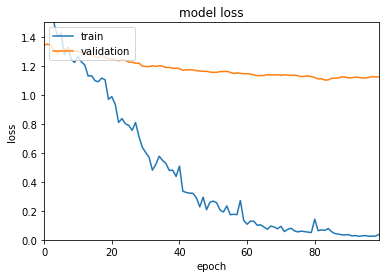

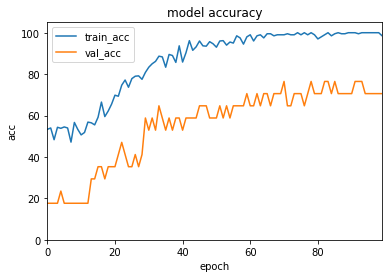

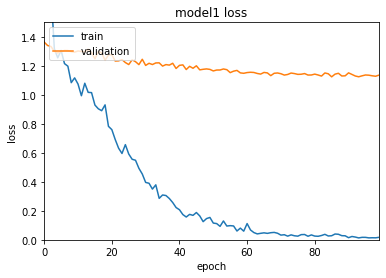

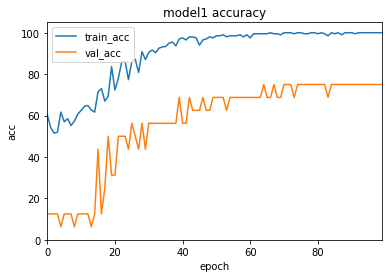

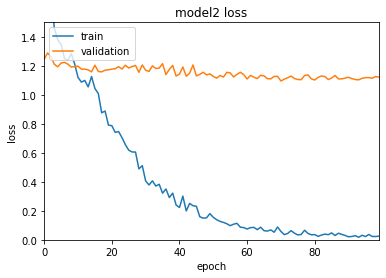

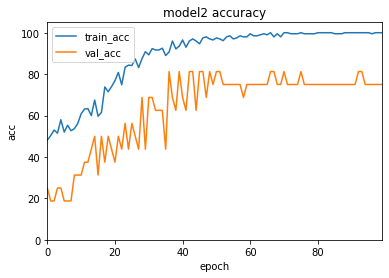

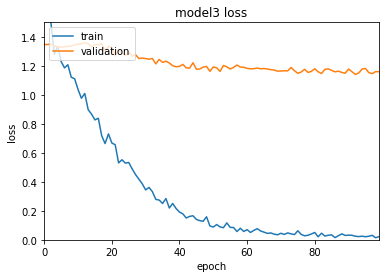

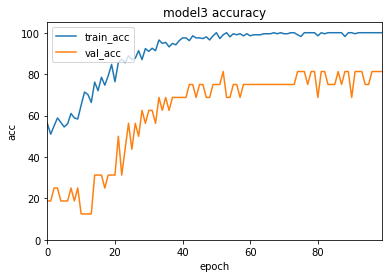

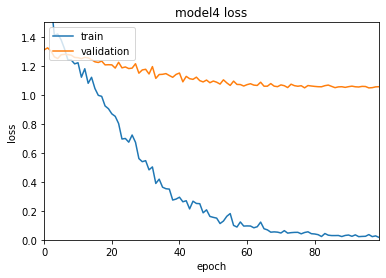

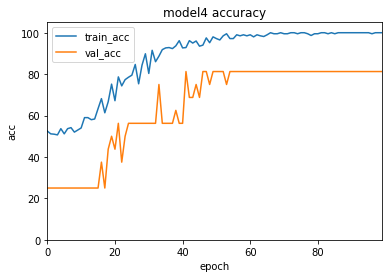

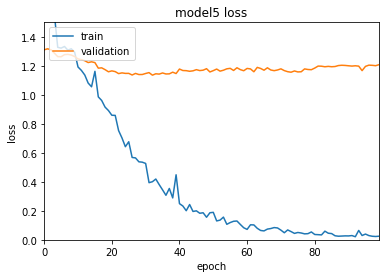

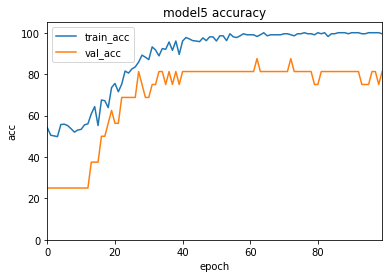

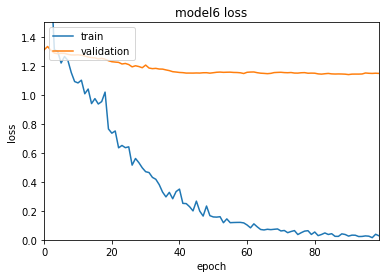

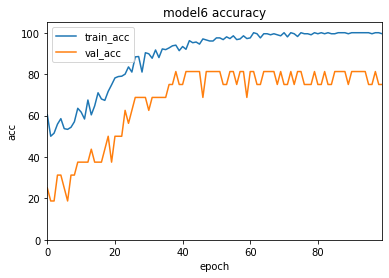

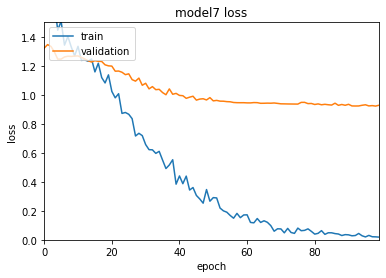

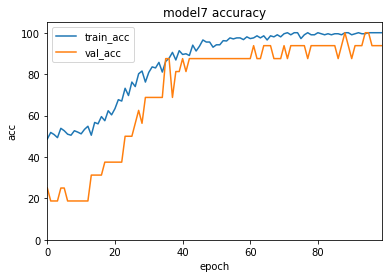

In [17]:
#Plotting loss
plt.plot(train_loss)
plt.plot(val_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 1.5])
plt.show()

#Plotting Accuracy
plt.plot(train_acc)
plt.plot(val_acc)
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train_acc', 'val_acc'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 105])
plt.show()

#Plotting loss
plt.plot(train_loss1)
plt.plot(val_loss1)
plt.title('model1 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 1.5])
plt.show()

#Plotting Accuracy
plt.plot(train_acc1)
plt.plot(val_acc1)
plt.title('model1 accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train_acc', 'val_acc'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 105])
plt.show()

#Plotting loss
plt.plot(train_loss2)
plt.plot(val_loss2)
plt.title('model2 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 1.5])
plt.show()

#Plotting Accuracy
plt.plot(train_acc2)
plt.plot(val_acc2)
plt.title('model2 accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train_acc', 'val_acc'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 105])
plt.show()

#Plotting loss
plt.plot(train_loss3)
plt.plot(val_loss3)
plt.title('model3 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 1.5])
plt.show()

#Plotting Accuracy
plt.plot(train_acc3)
plt.plot(val_acc3)
plt.title('model3 accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train_acc', 'val_acc'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 105])
plt.show()

#Plotting loss
plt.plot(train_loss4)
plt.plot(val_loss4)
plt.title('model4 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 1.5])
plt.show()

#Plotting Accuracy
plt.plot(train_acc4)
plt.plot(val_acc4)
plt.title('model4 accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train_acc', 'val_acc'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 105])
plt.show()

#Plotting loss
plt.plot(train_loss5)
plt.plot(val_loss5)
plt.title('model5 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 1.5])
plt.show()

#Plotting Accuracy
plt.plot(train_acc5)
plt.plot(val_acc5)
plt.title('model5 accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train_acc', 'val_acc'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 105])
plt.show()

#Plotting loss
plt.plot(train_loss6)
plt.plot(val_loss6)
plt.title('model6 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 1.5])
plt.show()

#Plotting Accuracy
plt.plot(train_acc6)
plt.plot(val_acc6)
plt.title('model6 accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train_acc', 'val_acc'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 105])
plt.show()

#Plotting loss
plt.plot(train_loss7)
plt.plot(val_loss7)
plt.title('model7 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 1.5])
plt.show()

#Plotting Accuracy
plt.plot(train_acc7)
plt.plot(val_acc7)
plt.title('model7 accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train_acc', 'val_acc'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 105])
plt.show()

Validation Accuracy |  70.58823529411765  PPV |  [0.84615385 0.25      ]  Recall |  [0.78571429 0.33333333]


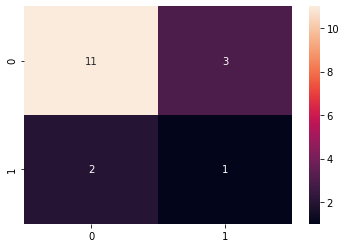

In [18]:
final_prediction = []
final_prediction_true = []

y_pred_list = []
test_loader = DataLoader(dataset=test_data, batch_size=1)
model.eval() #Model evaluation
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        final_prediction.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
accuracy = accuracy_score(testing_fold_Y_0, y_pred_list)
ppv = precision_score(testing_fold_Y_0, y_pred_list, average=None)
recall = recall_score(testing_fold_Y_0, y_pred_list, average=None)
print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
cf_matrix = confusion_matrix(testing_fold_Y_0, y_pred_list)
sn.heatmap(cf_matrix, annot=True)

for y in testing_fold_Y_0:
    final_prediction_true.append(y)

Validation Accuracy |  75.0  PPV |  [0.85714286 0.        ]  Recall |  [0.85714286 0.        ]


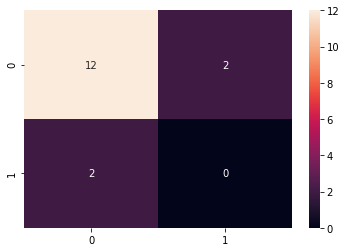

In [19]:
y_pred_list = []
test_loader = DataLoader(dataset=test_data1, batch_size=1)
model1.eval() #Model evaluation
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model1(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        final_prediction.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
accuracy = accuracy_score(testing_fold_Y_1, y_pred_list)
ppv = precision_score(testing_fold_Y_1, y_pred_list, average=None)
recall = recall_score(testing_fold_Y_1, y_pred_list, average=None)
print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
cf_matrix = confusion_matrix(testing_fold_Y_1, y_pred_list)
sn.heatmap(cf_matrix, annot=True)

for y in testing_fold_Y_1:
    final_prediction_true.append(y)

Validation Accuracy |  75.0  PPV |  [0.85714286 0.        ]  Recall |  [0.85714286 0.        ]


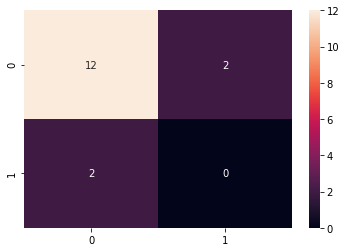

In [20]:
y_pred_list = []
test_loader = DataLoader(dataset=test_data2, batch_size=1)
model2.eval() #Model evaluation
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model2(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        final_prediction.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
accuracy = accuracy_score(testing_fold_Y_2, y_pred_list)
ppv = precision_score(testing_fold_Y_2, y_pred_list, average=None)
recall = recall_score(testing_fold_Y_2, y_pred_list, average=None)
print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
cf_matrix = confusion_matrix(testing_fold_Y_2, y_pred_list)
sn.heatmap(cf_matrix, annot=True)

for y in testing_fold_Y_2:
    final_prediction_true.append(y)

Validation Accuracy |  81.25  PPV |  [0.85714286 0.5       ]  Recall |  [0.92307692 0.33333333]


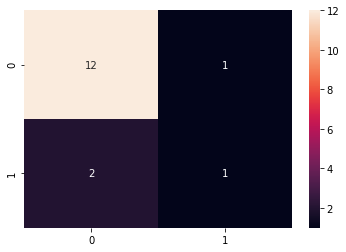

In [21]:
y_pred_list = []
test_loader = DataLoader(dataset=test_data3, batch_size=1)
model3.eval() #Model evaluation
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model3(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        final_prediction.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
accuracy = accuracy_score(testing_fold_Y_3, y_pred_list)
ppv = precision_score(testing_fold_Y_3, y_pred_list, average=None)
recall = recall_score(testing_fold_Y_3, y_pred_list, average=None)
print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
cf_matrix = confusion_matrix(testing_fold_Y_3, y_pred_list)
sn.heatmap(cf_matrix, annot=True)

for y in testing_fold_Y_3:
    final_prediction_true.append(y)

Validation Accuracy |  81.25  PPV |  [0.91666667 0.5       ]  Recall |  [0.84615385 0.66666667]


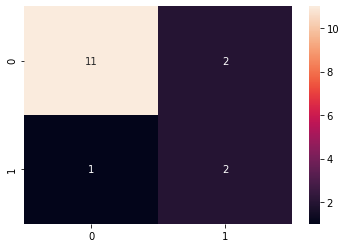

In [22]:
y_pred_list = []
test_loader = DataLoader(dataset=test_data4, batch_size=1)
model4.eval() #Model evaluation
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model4(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        final_prediction.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
accuracy = accuracy_score(testing_fold_Y_4, y_pred_list)
ppv = precision_score(testing_fold_Y_4, y_pred_list, average=None)
recall = recall_score(testing_fold_Y_4, y_pred_list, average=None)
print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
cf_matrix = confusion_matrix(testing_fold_Y_4, y_pred_list)
sn.heatmap(cf_matrix, annot=True)

for y in testing_fold_Y_4:
    final_prediction_true.append(y)

C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy |  81.25  PPV |  [0.8125 0.    ]  Recall |  [1. 0.]


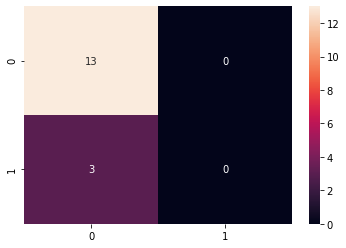

In [23]:
y_pred_list = []
test_loader = DataLoader(dataset=test_data5, batch_size=1)
model5.eval() #Model evaluation
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model5(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        final_prediction.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
accuracy = accuracy_score(testing_fold_Y_5, y_pred_list)
ppv = precision_score(testing_fold_Y_5, y_pred_list, average=None)
recall = recall_score(testing_fold_Y_5, y_pred_list, average=None)
print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
cf_matrix = confusion_matrix(testing_fold_Y_5, y_pred_list)
sn.heatmap(cf_matrix, annot=True)

for y in testing_fold_Y_5:
    final_prediction_true.append(y)

Validation Accuracy |  75.0  PPV |  [0.84615385 0.33333333]  Recall |  [0.84615385 0.33333333]


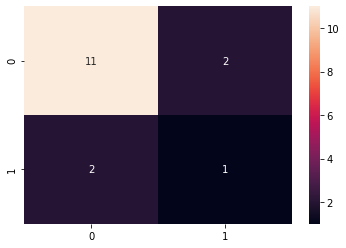

In [24]:
y_pred_list = []
test_loader = DataLoader(dataset=test_data6, batch_size=1)
model6.eval() #Model evaluation
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model6(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        final_prediction.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
accuracy = accuracy_score(testing_fold_Y_6, y_pred_list)
ppv = precision_score(testing_fold_Y_6, y_pred_list, average=None)
recall = recall_score(testing_fold_Y_6, y_pred_list, average=None)
print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
cf_matrix = confusion_matrix(testing_fold_Y_6, y_pred_list)
sn.heatmap(cf_matrix, annot=True)

for y in testing_fold_Y_6:
    final_prediction_true.append(y)

Validation Accuracy |  93.75  PPV |  [1.   0.75]  Recall |  [0.92307692 1.        ]


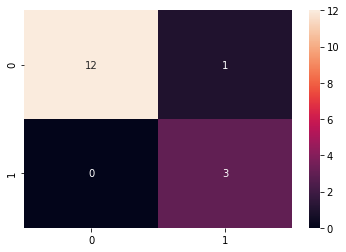

In [25]:
y_pred_list = []
test_loader = DataLoader(dataset=test_data7, batch_size=1)
model7.eval() #Model evaluation
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model7(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        final_prediction.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
accuracy = accuracy_score(testing_fold_Y_7, y_pred_list)
ppv = precision_score(testing_fold_Y_7, y_pred_list, average=None)
recall = recall_score(testing_fold_Y_7, y_pred_list, average=None)
print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
cf_matrix = confusion_matrix(testing_fold_Y_7, y_pred_list)
sn.heatmap(cf_matrix, annot=True)

for y in testing_fold_Y_7:
    final_prediction_true.append(y)

In [26]:
prediction_labels = []
true_labels = []

for x in range(0,len(final_prediction_true)):
    true_labels.append(final_prediction_true[x][0])
    prediction_labels.append(final_prediction[x][0][0])

prediction_labels

[1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0]

[[94 13]
 [14  8]]
Positive Predictive Value tp/(tp+fp):  0.38095238095238093
Accuracy Value (tp+tn)/(tp+fp+fn+tn):  0.7906976744186046
Recall Value tp/(tp+fn):  0.36363636363636365


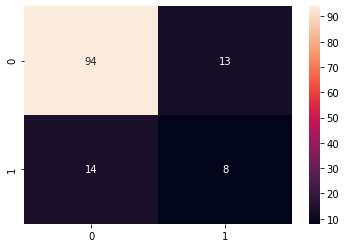

In [27]:
cf_matrix = confusion_matrix(true_labels, prediction_labels)
print(cf_matrix)
sn.heatmap(cf_matrix, annot=True)


accuracy = accuracy_score(true_labels, prediction_labels)
recall = recall_score(true_labels, prediction_labels, average=None)
prec_score = precision_score(true_labels, prediction_labels, average=None)
print('Positive Predictive Value tp/(tp+fp): ',prec_score[1]) 
print('Accuracy Value (tp+tn)/(tp+fp+fn+tn): ',accuracy) 
print('Recall Value tp/(tp+fn): ',recall[1]) 

In [28]:
#Line up Subjects by case number based on test_index in skf. This is done before smoting.
#Allows us to later check t-score to see if the models improve when using imputed data
#that we are able to classify the ones that have borderline t-scores (60 - 65 ish)
#Can create a histogram of the distribution based on correctly predicted vs incorrectly predicted


#Take ATP Simplified and apply to the unused subjects, and review what happens to the cases that were incorrectly classified.


In [29]:
Twin_Validation = pd.ExcelFile("Scaled Twin CTSA1y with labels sex GA.xlsx") #298 Features, CT1y SA1y GA Sex
Twin_Labels = pd.ExcelFile("Twin Labels.xlsx") #Labels for twins

twin_data = Twin_Validation.parse(Twin_Validation.sheet_names[0])
twin_label_data = Twin_Labels.parse(Twin_Labels.sheet_names[0])
twin_data_features = twin_data.loc[:, twin_data.columns]
twin_data_features = twin_data_features.drop(['ROI','MATCH','INDEX','MATCH2','INDEX2', 'ATP', 'HYP', 'ATP Label', 'HYP Middle', 'HYP Label'], axis=1)
twin_data_features = twin_data_features.dropna()
twin_data_features = twin_data_features.drop(['ATP Middle'], axis=1)
twin_labels = twin_label_data.loc[:, twin_label_data.columns]
twin_labels = twin_labels.drop(['ROI','ATP Label', 'HYP Middle', 'HYP Label'], axis=1)
twin_labels = twin_labels.dropna()
print(twin_data_features.shape)
print(twin_labels.shape)

(133, 298)
(133, 1)


In [30]:
type(twin_data_features) #Currently dataframe, needs to be numpy array
td_features = twin_data_features.to_numpy()
td_data = testData(torch.FloatTensor(td_features))

t_labels = twin_labels.to_numpy()

Validation Accuracy |  72.93233082706767  PPV |  [0.94897959 0.11428571]  Recall |  [0.75       0.44444444]
[[93 31]
 [ 5  4]]


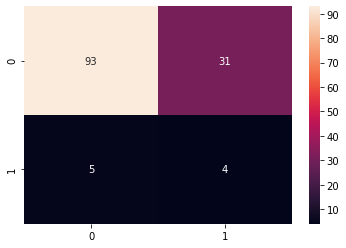

In [31]:
y_pred_list = []
test_loader = DataLoader(dataset=td_data, batch_size=1)
model.eval() #Model evaluation
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        final_prediction.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
accuracy = accuracy_score(t_labels, y_pred_list)
ppv = precision_score(t_labels, y_pred_list, average=None)
recall = recall_score(t_labels, y_pred_list, average=None)
print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
cf_matrix = confusion_matrix(t_labels, y_pred_list)
sn.heatmap(cf_matrix, annot=True)
print(cf_matrix)

Validation Accuracy |  75.18796992481202  PPV |  [0.94174757 0.1       ]  Recall |  [0.78225806 0.33333333]
[[97 27]
 [ 6  3]]


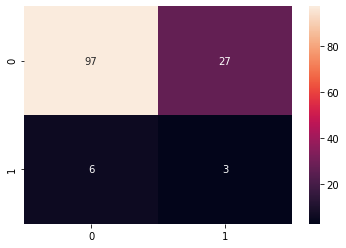

In [32]:
y_pred_list1 = []
test_loader = DataLoader(dataset=td_data, batch_size=1)
model1.eval() #Model evaluation
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model1(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list1.append(y_pred_tag.cpu().numpy())
        final_prediction.append(y_pred_tag.cpu().numpy())

y_pred_list1 = [a.squeeze().tolist() for a in y_pred_list1]
accuracy = accuracy_score(t_labels, y_pred_list1)
ppv = precision_score(t_labels, y_pred_list1, average=None)
recall = recall_score(t_labels, y_pred_list1, average=None)
print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
cf_matrix = confusion_matrix(t_labels, y_pred_list1)
sn.heatmap(cf_matrix, annot=True)
print(cf_matrix)

Validation Accuracy |  78.19548872180451  PPV |  [0.94392523 0.11538462]  Recall |  [0.81451613 0.33333333]
[[101  23]
 [  6   3]]


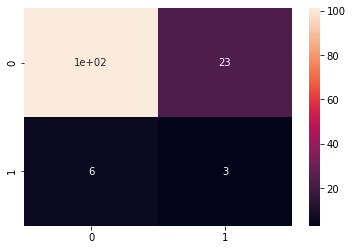

In [33]:
y_pred_list2 = []
test_loader = DataLoader(dataset=td_data, batch_size=1)
model2.eval() #Model evaluation
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model2(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list2.append(y_pred_tag.cpu().numpy())
        final_prediction.append(y_pred_tag.cpu().numpy())

y_pred_list2 = [a.squeeze().tolist() for a in y_pred_list2]
accuracy = accuracy_score(t_labels, y_pred_list2)
ppv = precision_score(t_labels, y_pred_list2, average=None)
recall = recall_score(t_labels, y_pred_list2, average=None)
print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
cf_matrix = confusion_matrix(t_labels, y_pred_list2)
sn.heatmap(cf_matrix, annot=True)
print(cf_matrix)

Validation Accuracy |  77.44360902255639  PPV |  [0.95192308 0.13793103]  Recall |  [0.7983871  0.44444444]
[[99 25]
 [ 5  4]]


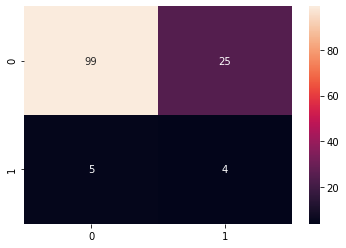

In [34]:
y_pred_list3 = []
test_loader = DataLoader(dataset=td_data, batch_size=1)
model3.eval() #Model evaluation
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model3(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list3.append(y_pred_tag.cpu().numpy())
        final_prediction.append(y_pred_tag.cpu().numpy())

y_pred_list3 = [a.squeeze().tolist() for a in y_pred_list3]
accuracy = accuracy_score(t_labels, y_pred_list3)
ppv = precision_score(t_labels, y_pred_list3, average=None)
recall = recall_score(t_labels, y_pred_list3, average=None)
print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
cf_matrix = confusion_matrix(t_labels, y_pred_list3)
sn.heatmap(cf_matrix, annot=True)
print(cf_matrix)

Validation Accuracy |  76.69172932330827  PPV |  [0.95145631 0.13333333]  Recall |  [0.79032258 0.44444444]
[[98 26]
 [ 5  4]]


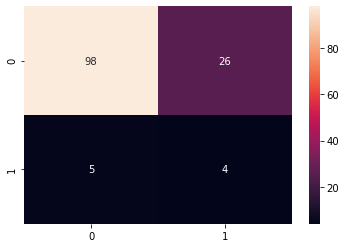

In [35]:
y_pred_list4 = []
test_loader = DataLoader(dataset=td_data, batch_size=1)
model4.eval() #Model evaluation
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model4(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list4.append(y_pred_tag.cpu().numpy())
        final_prediction.append(y_pred_tag.cpu().numpy())

y_pred_list4 = [a.squeeze().tolist() for a in y_pred_list4]
accuracy = accuracy_score(t_labels, y_pred_list4)
ppv = precision_score(t_labels, y_pred_list4, average=None)
recall = recall_score(t_labels, y_pred_list4, average=None)
print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
cf_matrix = confusion_matrix(t_labels, y_pred_list4)
sn.heatmap(cf_matrix, annot=True)
print(cf_matrix)

Validation Accuracy |  81.203007518797  PPV |  [0.95412844 0.16666667]  Recall |  [0.83870968 0.44444444]
[[104  20]
 [  5   4]]


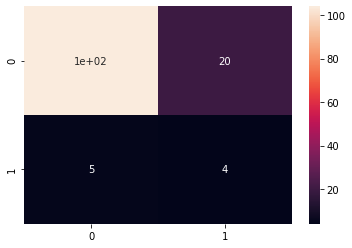

In [36]:
y_pred_list5 = []
test_loader = DataLoader(dataset=td_data, batch_size=1)
model5.eval() #Model evaluation
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model5(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list5.append(y_pred_tag.cpu().numpy())
        final_prediction.append(y_pred_tag.cpu().numpy())

y_pred_list5 = [a.squeeze().tolist() for a in y_pred_list5]
accuracy = accuracy_score(t_labels, y_pred_list5)
ppv = precision_score(t_labels, y_pred_list5, average=None)
recall = recall_score(t_labels, y_pred_list5, average=None)
print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
cf_matrix = confusion_matrix(t_labels, y_pred_list5)
sn.heatmap(cf_matrix, annot=True)
print(cf_matrix)

Validation Accuracy |  76.69172932330827  PPV |  [0.94285714 0.10714286]  Recall |  [0.7983871  0.33333333]
[[99 25]
 [ 6  3]]


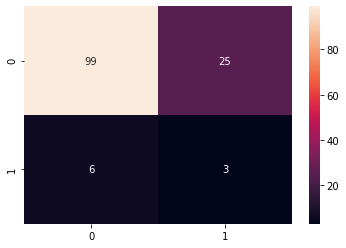

In [37]:
y_pred_list6 = []
test_loader = DataLoader(dataset=td_data, batch_size=1)
model6.eval() #Model evaluation
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model6(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list6.append(y_pred_tag.cpu().numpy())
        final_prediction.append(y_pred_tag.cpu().numpy())

y_pred_list6 = [a.squeeze().tolist() for a in y_pred_list6]
accuracy = accuracy_score(t_labels, y_pred_list6)
ppv = precision_score(t_labels, y_pred_list6, average=None)
recall = recall_score(t_labels, y_pred_list6, average=None)
print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
cf_matrix = confusion_matrix(t_labels, y_pred_list6)
sn.heatmap(cf_matrix, annot=True)
print(cf_matrix)

Validation Accuracy |  83.45864661654136  PPV |  [0.95535714 0.19047619]  Recall |  [0.86290323 0.44444444]
[[107  17]
 [  5   4]]


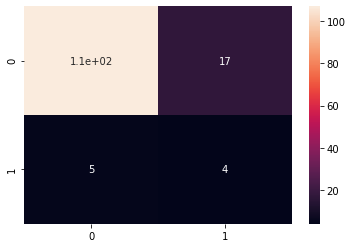

In [38]:
y_pred_list7 = []
test_loader = DataLoader(dataset=td_data, batch_size=1)
model7.eval() #Model evaluation
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model7(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list7.append(y_pred_tag.cpu().numpy())
        final_prediction.append(y_pred_tag.cpu().numpy())

y_pred_list7 = [a.squeeze().tolist() for a in y_pred_list7]
accuracy = accuracy_score(t_labels, y_pred_list7)
ppv = precision_score(t_labels, y_pred_list7, average=None)
recall = recall_score(t_labels, y_pred_list7, average=None)
print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
cf_matrix = confusion_matrix(t_labels, y_pred_list7)
sn.heatmap(cf_matrix, annot=True)
print(cf_matrix)

In [39]:
final_twin_pred = []
for x in range(0,133):
    count = 0
    if(y_pred_list[x] == 1.0):
        count += 1
    if(y_pred_list1[x] == 1.0):
        count += 1
    if(y_pred_list2[x] == 1.0):
        count += 1
    if(y_pred_list3[x] == 1.0):
        count += 1
    if(y_pred_list4[x] == 1.0):
        count += 1
    if(y_pred_list5[x] == 1.0):
        count += 1
    if(y_pred_list6[x] == 1.0):
        count += 1
    if(y_pred_list7[x] == 1.0):
        count += 1
    if(count > 4):
        final_twin_pred.append(1.0)
    else:
        final_twin_pred.append(0.0)

print(final_twin_pred)

[0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]


Validation Accuracy |  81.203007518797  PPV |  [0.95412844 0.16666667]  Recall |  [0.83870968 0.44444444]
[[104  20]
 [  5   4]]


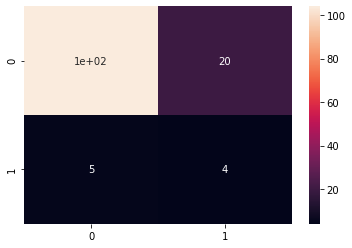

In [40]:
accuracy = accuracy_score(t_labels, final_twin_pred)
ppv = precision_score(t_labels, final_twin_pred, average=None)
recall = recall_score(t_labels, final_twin_pred, average=None)
print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
cf_matrix = confusion_matrix(t_labels, final_twin_pred)
sn.heatmap(cf_matrix, annot=True)
print(cf_matrix)